XGBoost to predict streamflow. Forcings are aggregated from hourly to daily to match streamflow resolution.
Test generalization by training and testing on different stations

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn import metrics
from datetime import datetime, timedelta
import hydroeval
import netCDF4 as nc
import xgboost as xgb
import scipy as sp
from src import load_data, evaluate

np.random.seed(0)

time_stamp = datetime.now().strftime('%Y%m%d-%H%M%S')
time_stamp

'20190728-101329'

In [2]:
station_data_dict = load_data.load_train_test_gridded_aggregatedForcings(include_all_forcing_vars=False)

In [3]:
landcover, landcover_legend = load_data.load_landcover_reduced()

../src/load_data.py:242: UserWarning: WARNING: valid_range not used since it
cannot be safely cast to variable data type
  landcover_fullres = np.array(landcover_nc['Band1'][:])[::-1,:]


In [4]:
station_cell_mapping = load_data.get_station_cell_mapping()

In [5]:
rdrs_data, rdrs_var_names, rdrs_time_index, lats, lons = load_data.load_rdrs_forcings(as_grid=True, include_lat_lon=True)

data_runoff = load_data.load_discharge_gr4j_vic()
data_runoff = data_runoff[~pd.isna(data_runoff['runoff'])]
gauge_info = pd.read_csv('../data/gauge_info.csv')[['ID', 'Lat', 'Lon']]
data_runoff = pd.merge(data_runoff, gauge_info, left_on='station', right_on='ID').drop('ID', axis=1)

for station in station_data_dict.keys():
    station_lat = data_runoff[data_runoff['station'] == station]['Lat'].values[0]
    station_lon = data_runoff[data_runoff['station'] == station]['Lon'].values[0]
    # find nearest cell
    station_idx = np.argmin(np.square(lats - station_lat) + np.square(lons - station_lon))
    station_row = station_idx // rdrs_data.shape[3]
    station_col = station_idx % rdrs_data.shape[3]
    
    for i in range(len(landcover_legend)):
        station_data_dict[station]['{}'.format(landcover_legend[i])] = landcover[i,station_row,station_col]

In [6]:
test_station_fraction = 0.25
val_station_fraction = 0.1
num_test_stations = int(len(station_data_dict.keys()) * test_station_fraction)
num_val_stations = int(len(station_data_dict.keys()) * val_station_fraction)
test_stations = np.random.choice(list(station_data_dict.keys()), size=num_test_stations, replace=False)
train_stations = np.array(list(s for s in station_data_dict.keys() if s not in test_stations))
val_stations = np.random.choice(train_stations, size=num_test_stations, replace=False)
train_stations = np.array(list(s for s in station_data_dict.keys() if (s not in test_stations) and (s not in val_stations)))
train_stations, test_stations, val_stations

(array(['02GA010', '02GA038', '02GA047', '02GB007', '02GC002', '02GC007',
        '02GC018', '02GE007', '02GG002', '02GG003', '02GG009', '04159492',
        '04161820', '04165500', '04174500', '04176500', '04198000',
        '04199000', '04199500', '04208504', '04213000', '04213500',
        '04214500', '04215500'], dtype='<U8'),
 array(['04166500', '04164000', '04177000', '02GB001', '02GC026',
        '04196800', '04193500', '02GD004', '04160600', '04197100',
        '04195820'], dtype='<U8'),
 array(['04207200', '04166100', '04159900', '04200500', '04215000',
        '04212100', '04209000', '02GG013', '02GC010', '02GG006', '02GA018'],
       dtype='<U8'))

In [7]:
# Create test and train splits for each station (by time), then create predictions for each subbasin
history = 7
train_start = datetime.strptime('2010-01-01', '%Y-%m-%d') + timedelta(days=history + 1)
train_end = '2012-12-31'
test_start = datetime.strptime(train_end, '%Y-%m-%d') + timedelta(days=1)
test_end = '2014-12-31'

data = pd.DataFrame()
data = pd.concat([station_data_dict[station].reset_index() for station in station_data_dict.keys()], ignore_index=True)

train = data[(data['date'] >= train_start) & (data['date'] <= train_end) & (data['station'].isin(train_stations))].copy()
val = data[(data['date'] >= train_start) & (data['date'] <= train_end) & (data['station'].isin(val_stations))].copy()    
test = data[(data['date'] >= test_start) & (data['date'] <= test_end) & (data['station'].isin(test_stations))].copy()
print('Shapes: train {}, val {}, test {}'.format(train.shape, val.shape, test.shape))

val = [(train.drop(['station', 'date', 'runoff'], axis=1), train['runoff']), 
       (val.drop(['station', 'date', 'runoff'], axis=1), val['runoff'])]

m = xgb.XGBRegressor(n_estimators=1000, n_jobs=44, random_state=123, colsample_bylevel=.8357617548460161,
                    colsample_bytree=0.7279736118769715, gamma=0.6959743989532903, learning_rate=0.1456725523229726, max_depth=3, min_child_weight=5,
                     reg_alpha=45.191905388077004, reg_lambda=8.021568667278883, subsample=0.9708847409794326)
m.fit(train.drop(['station', 'date', 'runoff'], axis=1), train['runoff'], eval_set=val, eval_metric='rmse', early_stopping_rounds=200, verbose=True)

test = test[~pd.isna(test['runoff'])]

predict = data[(data['date'] >= test_start) & (data['date'] <= test_end)].copy()
predict['is_test_station'] = predict['station'].apply(lambda s: s in test_stations)
predict['actual'] = predict['runoff']
predict['runoff'] = np.nan
predict['runoff'] = m.predict(predict.drop(['station', 'actual', 'date', 'runoff', 'is_test_station'], axis=1))

/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


Shapes: train (25073, 8746), val (11937, 8746), test (8030, 8746)


/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	validation_0-rmse:29.1438	validation_1-rmse:22.6158
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 200 rounds.
[1]	validation_0-rmse:27.8847	validation_1-rmse:21.8496
[2]	validation_0-rmse:26.9066	validation_1-rmse:22.3021
[3]	validation_0-rmse:26.0194	validation_1-rmse:22.3864
[4]	validation_0-rmse:25.3119	validation_1-rmse:22.4168
[5]	validation_0-rmse:24.6922	validation_1-rmse:22.4806
[6]	validation_0-rmse:24.1498	validation_1-rmse:22.6829
[7]	validation_0-rmse:23.681	validation_1-rmse:22.8919
[8]	validation_0-rmse:23.2539	validation_1-rmse:22.9346
[9]	validation_0-rmse:22.9082	validation_1-rmse:22.999
[10]	validation_0-rmse:22.5765	validation_1-rmse:22.8808
[11]	validation_0-rmse:22.2499	validation_1-rmse:23.0413
[12]	validation_0-rmse:21.984	validation_1-rmse:23.0742
[13]	validation_0-rmse:21.7848	validation_1-rmse:23.1902
[14]	validation_0-rmse:21.5769	validation_1-rmse:23.229

02GA010 	NSE: -0.3460887072629828 	MSE: 641.7794892465344 (clipped to 0)
02GA018 	NSE: -0.14921033562986197 	MSE: 288.62783085925423 (clipped to 0)
02GA038 	NSE: -0.06566719878395522 	MSE: 175.343236487712 (clipped to 0)
02GA047 	NSE: -0.812598418634354 	MSE: 142.08963474386474 (clipped to 0)
02GB001 	NSE: -0.9263974866343105 	MSE: 14467.004707525191 (clipped to 0)
02GB007 	NSE: -0.045862462422527894 	MSE: 32.70622611992248 (clipped to 0)
02GC002 	NSE: -0.032910724462249075 	MSE: 132.73216258545114 (clipped to 0)
02GC007 	NSE: -1.0729409572692994 	MSE: 62.43976864778022 (clipped to 0)
02GC010 	NSE: -0.09391264814181155 	MSE: 65.03301919899796 (clipped to 0)
02GC018 	NSE: -0.015552131418658632 	MSE: 68.78009784508127 (clipped to 0)
02GC026 	NSE: -0.41651364100777477 	MSE: 227.82178902921532 (clipped to 0)
02GD004 	NSE: -0.052745567340201305 	MSE: 57.9674064596324 (clipped to 0)
02GE007 	NSE: -0.0011755618343125551 	MSE: 36.21758449773119 (clipped to 0)
02GG002 	NSE: -0.1885657927703812 

../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: Ru

04165500 	NSE: -0.6779943125175187 	MSE: 751.1691183070218 (clipped to 0)
04166100 	NSE: -1.111493877217848 	MSE: 15.484234279002006 (clipped to 0)
04166500 	NSE: -0.004526326306800055 	MSE: 34.72074162345609 (clipped to 0)
04174500 	NSE: -1.1505034965084282 	MSE: 203.38222645738279 (clipped to 0)


../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: Ru

04176500 	NSE: -0.3365636623457928 	MSE: 912.9721762896879 (clipped to 0)
04177000 	NSE: -0.17223608864569262 	MSE: 31.591563087369053 (clipped to 0)
04193500 	NSE: -0.38397457346272823 	MSE: 97986.43676879635 (clipped to 0)
04195820 	NSE: 0.1216304157262803 	MSE: 1031.0252422918782 (clipped to 0)


../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: Ru

04196800 	NSE: -0.01402600690904543 	MSE: 303.4457483239024 (clipped to 0)
04197100 	NSE: -0.0034393337426839032 	MSE: 102.91716297857968 (clipped to 0)
04198000 	NSE: -0.050440460956422406 	MSE: 7760.191303511251 (clipped to 0)
04199000 	NSE: -0.08653380374787467 	MSE: 1111.093053041432 (clipped to 0)


../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: Ru

04199500 	NSE: -0.0749362435241876 	MSE: 434.97093216893234 (clipped to 0)
04200500 	NSE: -0.11894298221080324 	MSE: 1119.731787676527 (clipped to 0)
04207200 	NSE: -5.189063590678683 	MSE: 144.86302524503242 (clipped to 0)
04208504 	NSE: -0.6926248744052224 	MSE: 1652.8966940081998 (clipped to 0)
04209000 	NSE: 0.08902231518761328 	MSE: 284.8226535974188 (clipped to 0)
04212100 	NSE: -0.4096488749613163 	MSE: 2069.8227369428114 (clipped to 0)


../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: Ru

04213000 	NSE: -0.2418361583997839 	MSE: 222.87138706096712 (clipped to 0)
04213500 	NSE: -0.3569787192542764 	MSE: 1390.1118561619612 (clipped to 0)
04214500 	NSE: -0.10398369268648167 	MSE: 133.0709784726684 (clipped to 0)
04215000 	NSE: -0.04730193725005738 	MSE: 100.59629694450565 (clipped to 0)
04215500 	NSE: -0.10489718291094685 	MSE: 199.52776004422606 (clipped to 0)
Train Median NSE (clipped to 0) -0.10489718291094685 / Min -5.189063590678683 / Max 0.08902231518761328
Train Median MSE (clipped to 0) 199.52776004422606 / Min 15.484234279002006 / Max 7760.191303511251
Test Median NSE (clipped to 0) -0.052745567340201305 / Min -0.9263974866343105 / Max 0.1216304157262803
Test Median MSE (clipped to 0) 227.82178902921532 / Min 28.93246680897764 / Max 97986.43676879635


../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../src/evaluate.py:44: Ru

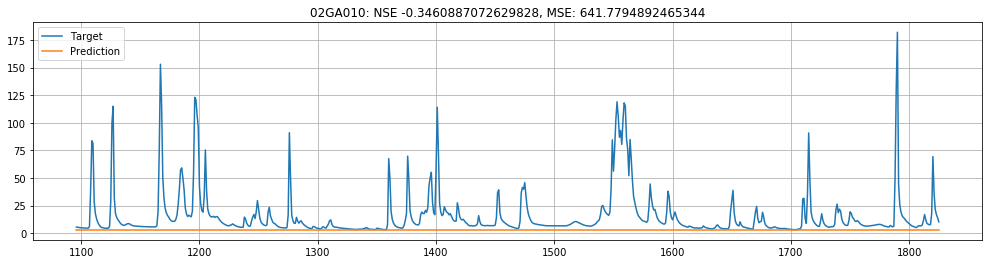

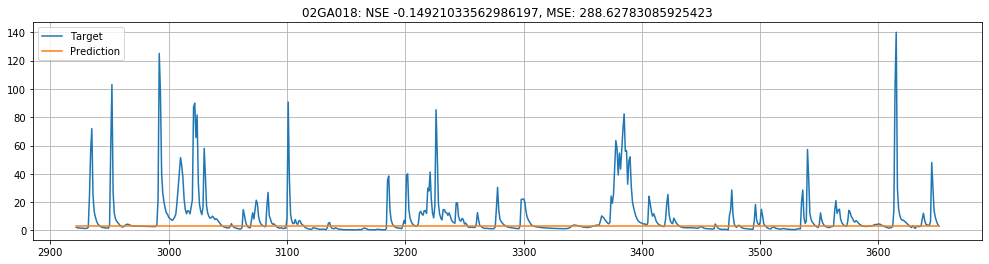

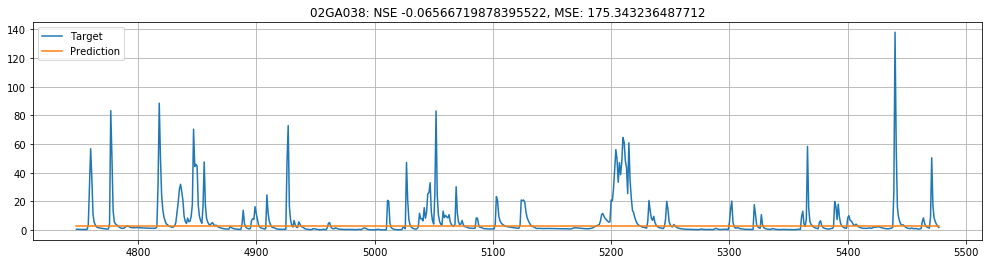

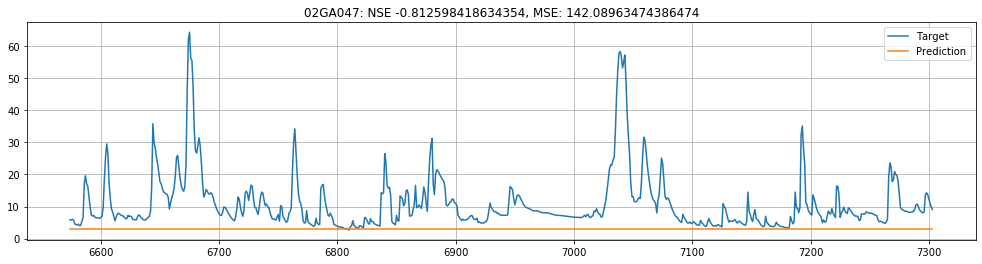

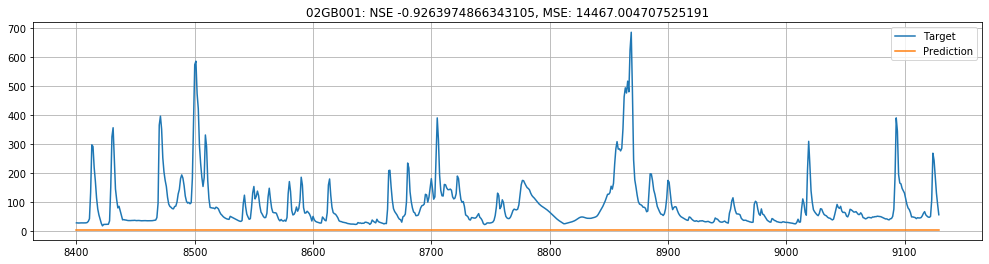

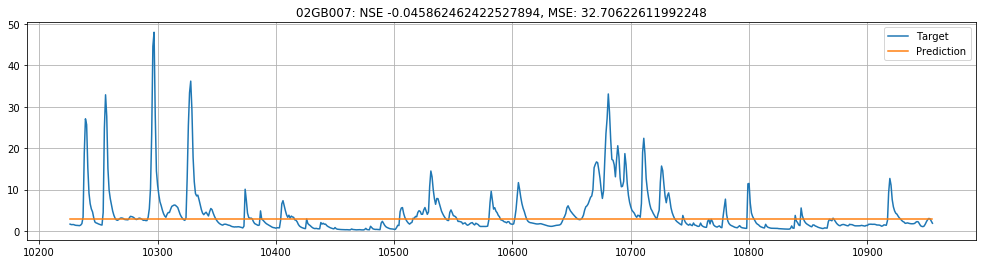

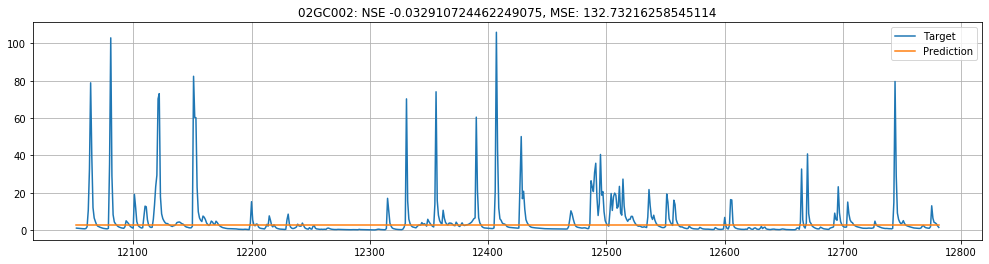

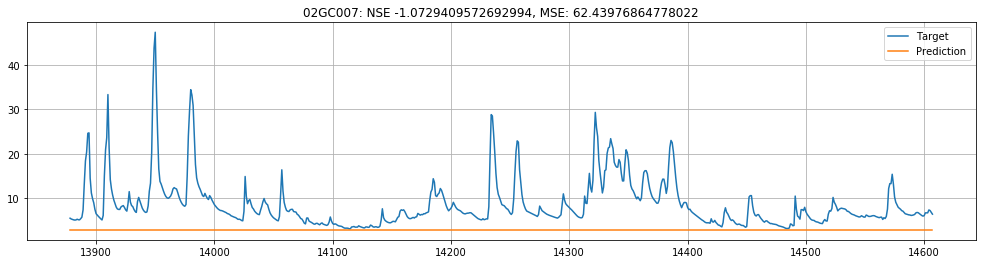

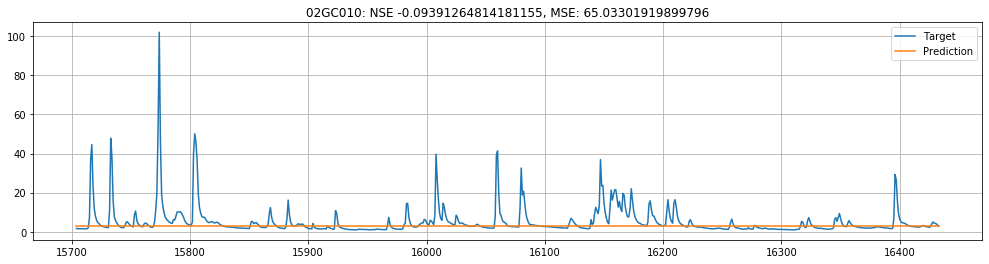

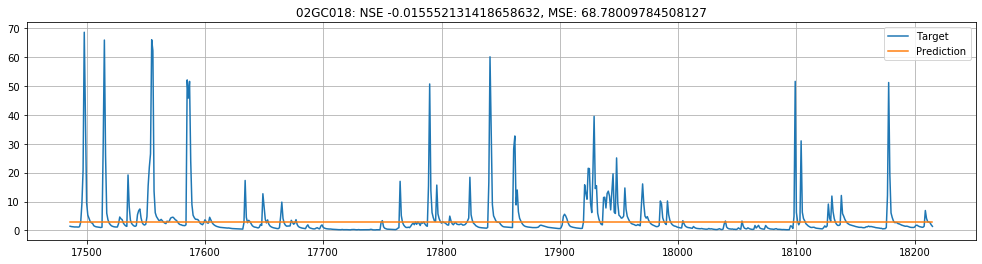

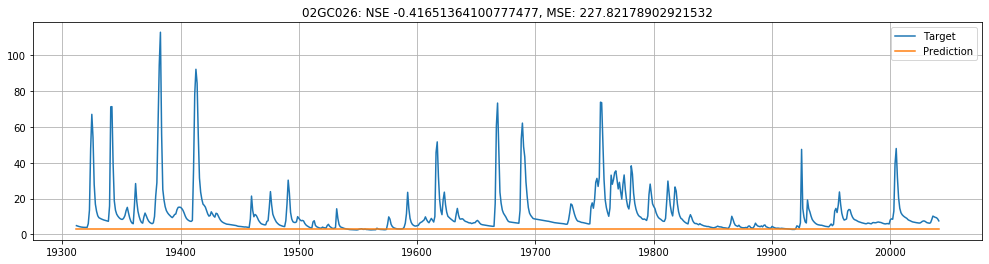

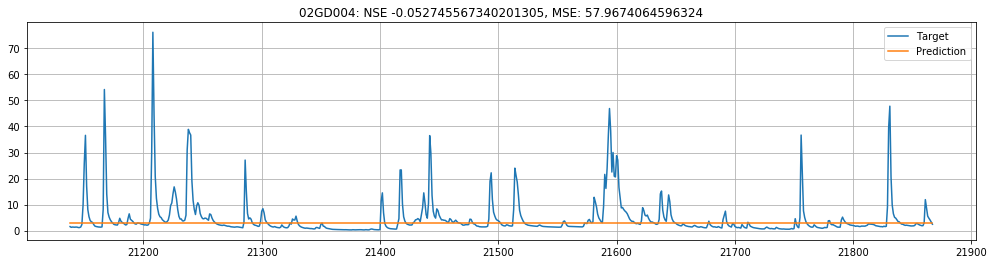

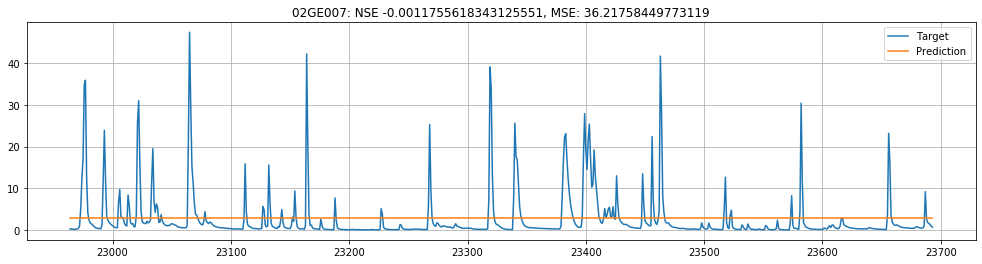

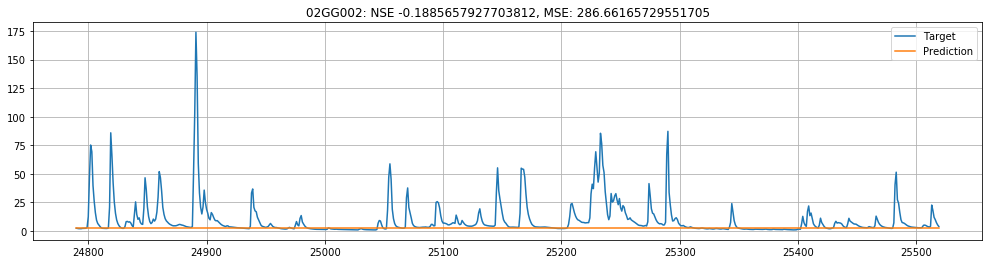

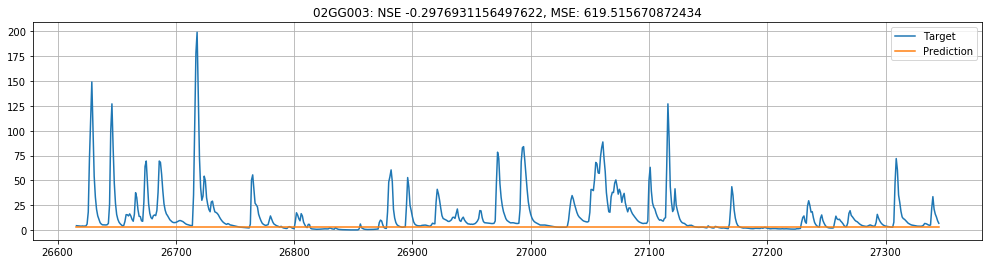

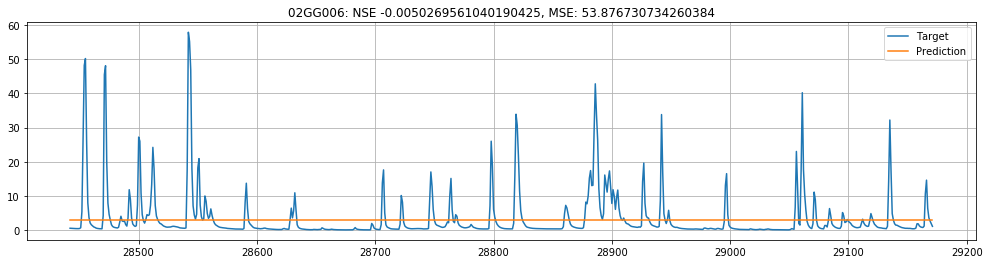

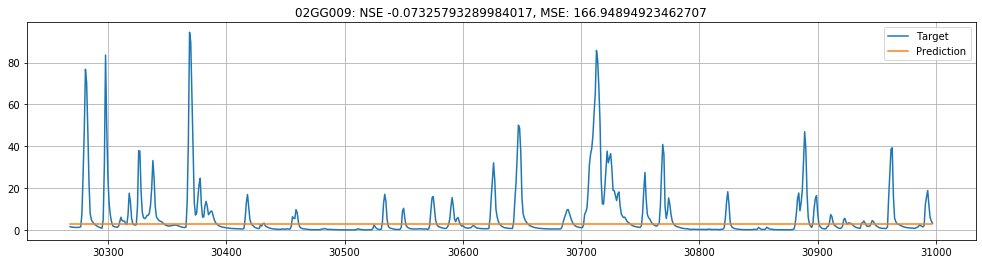

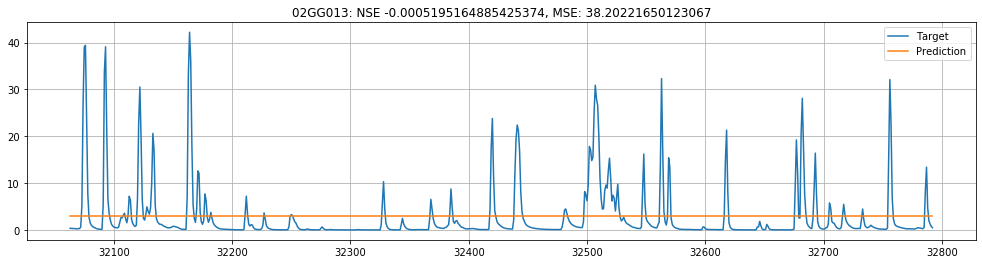

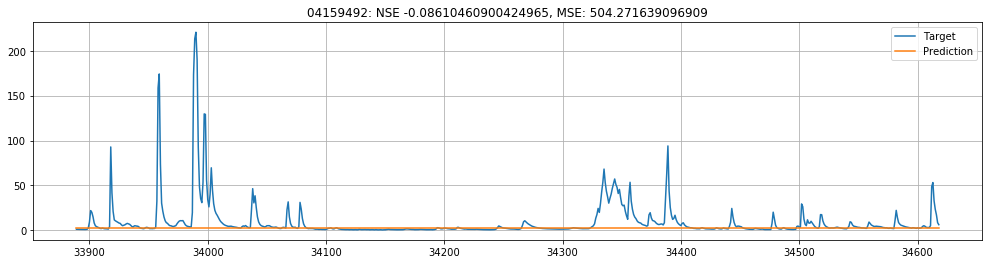

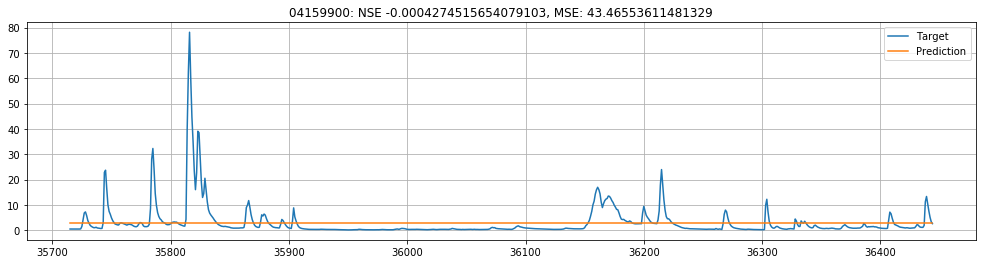

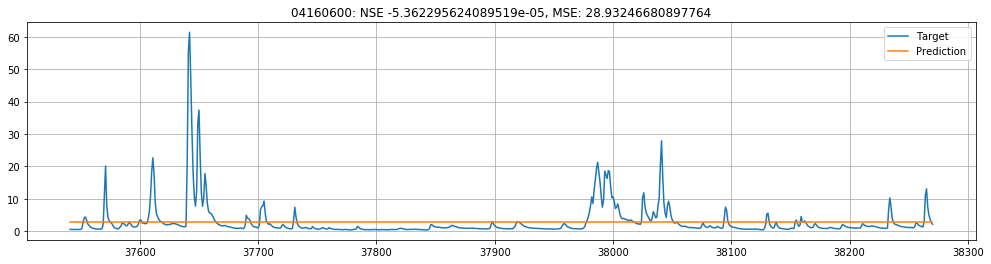

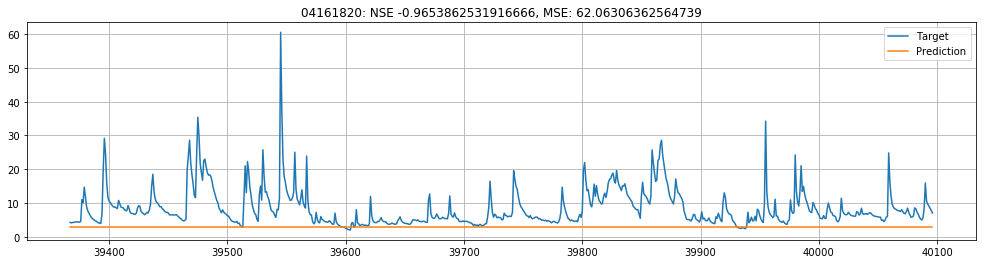

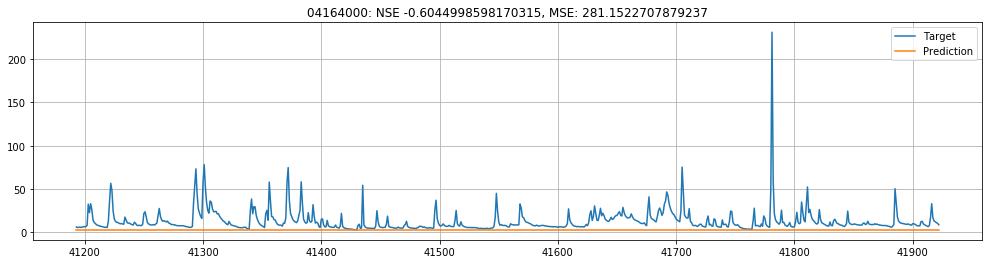

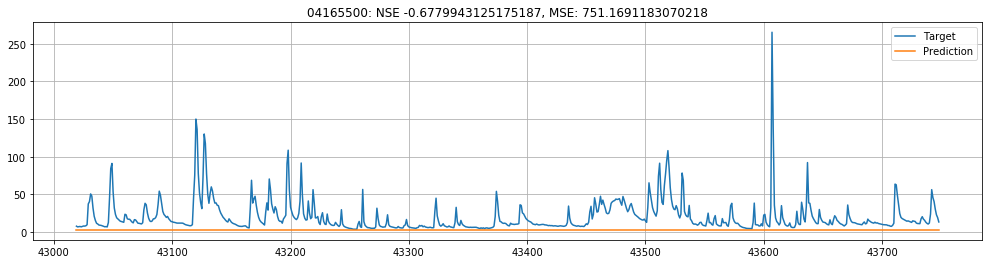

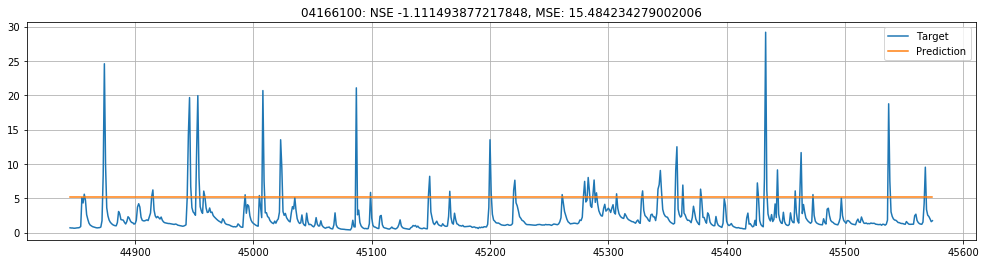

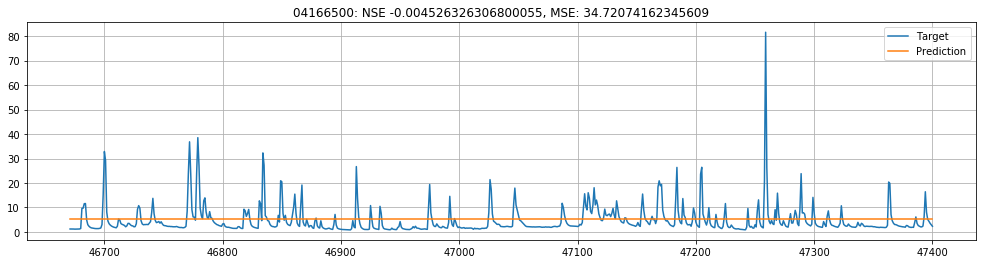

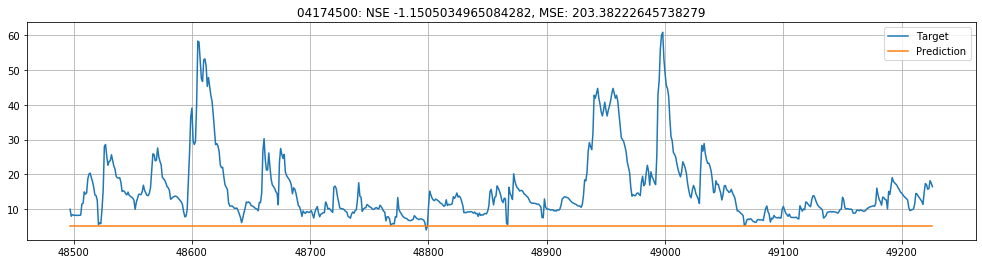

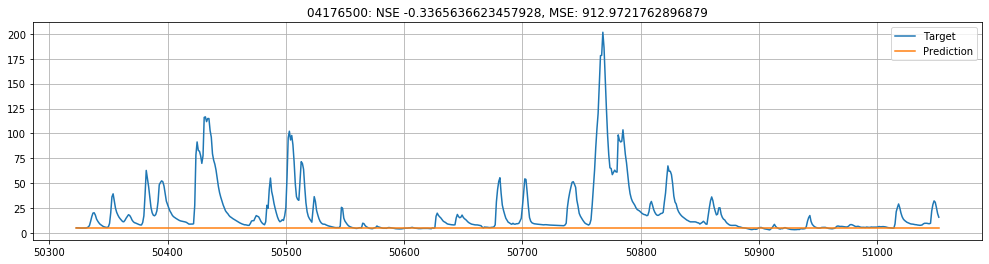

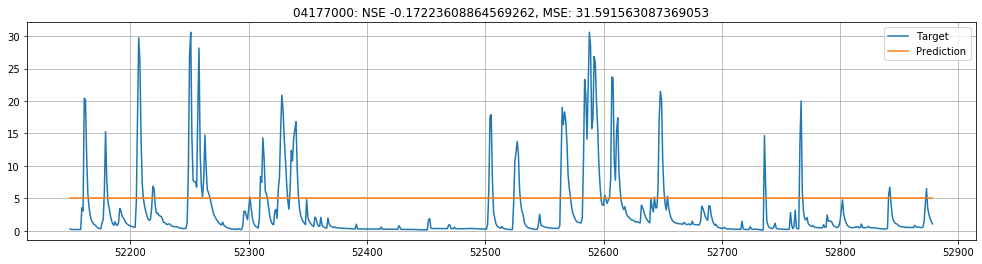

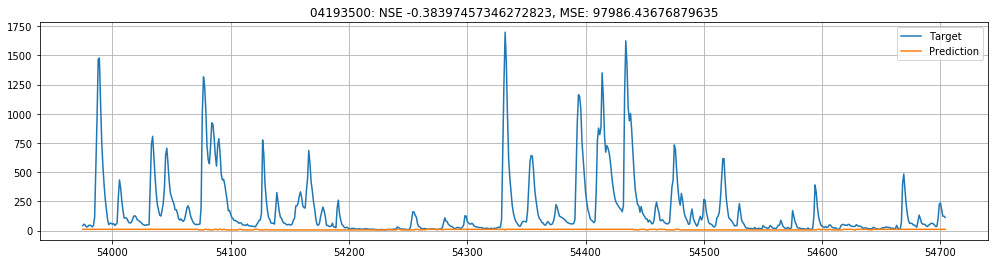

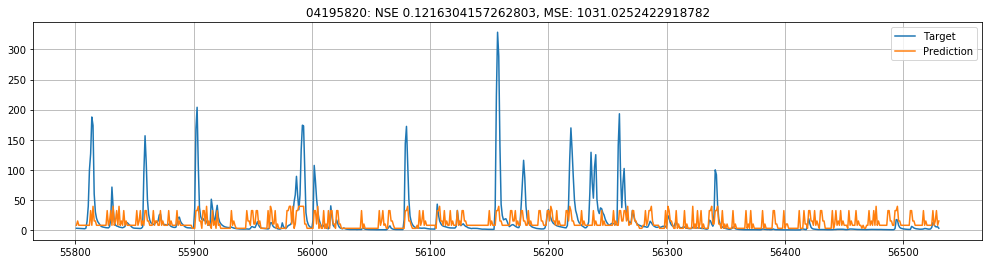

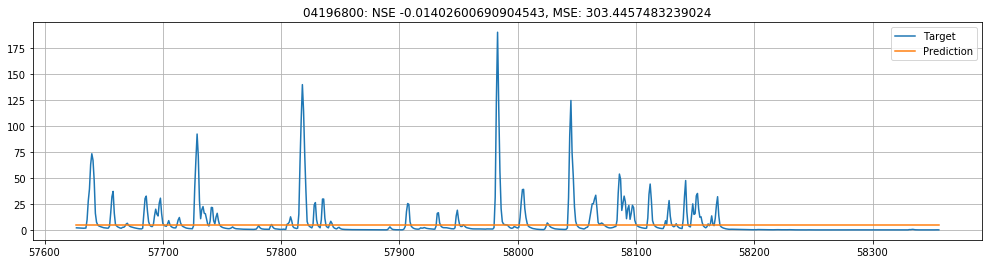

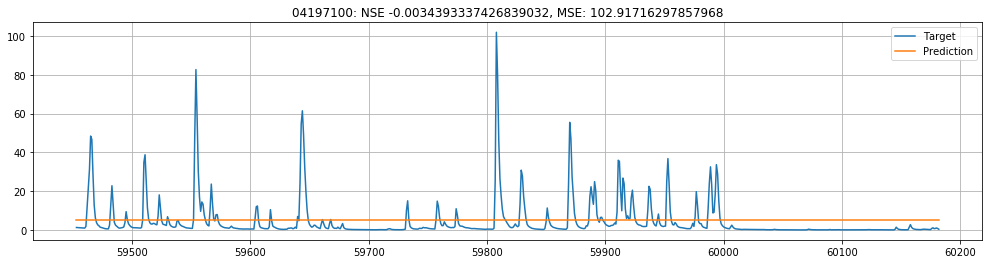

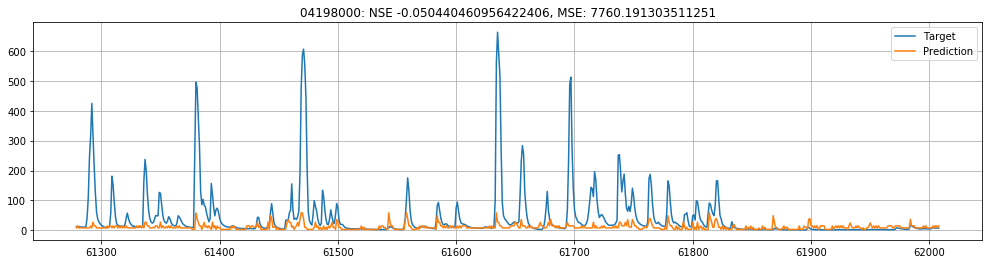

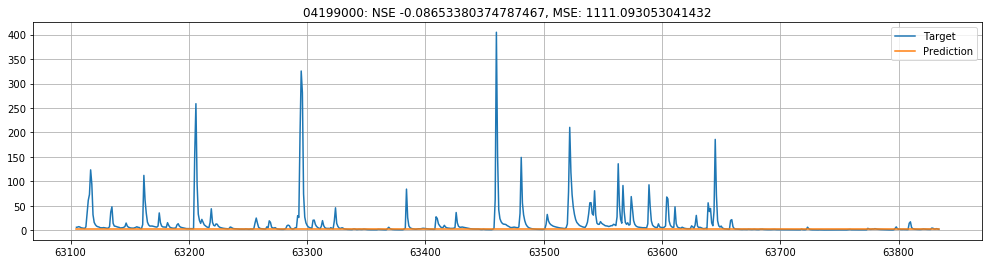

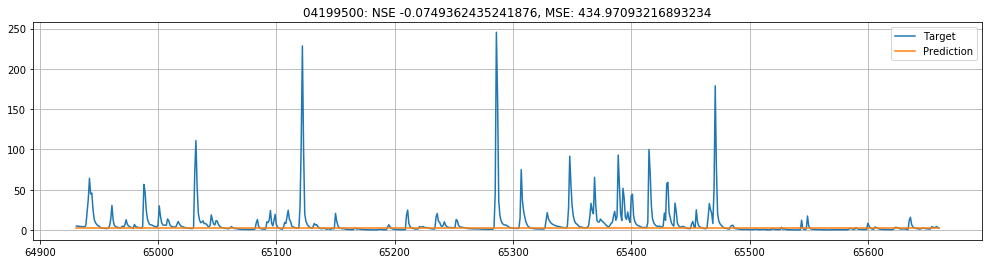

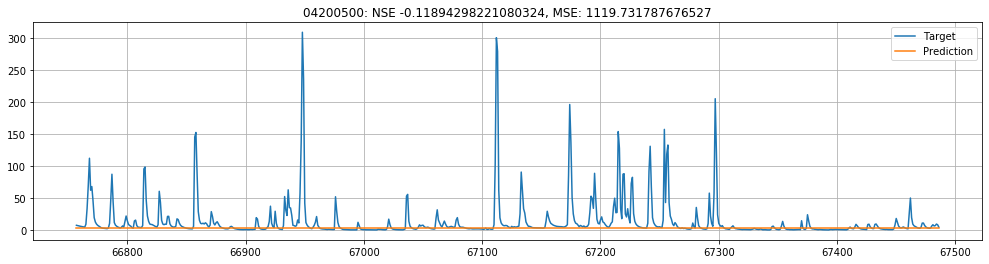

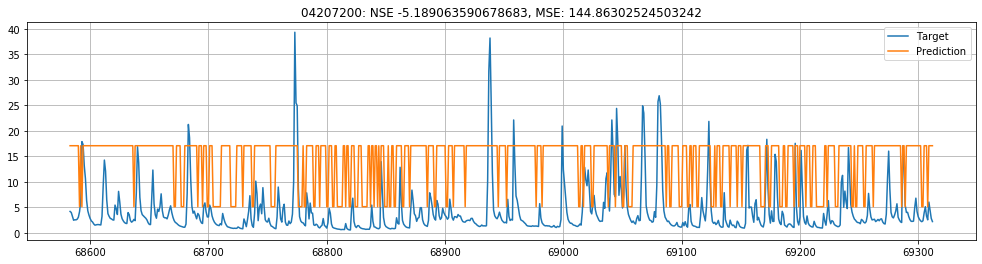

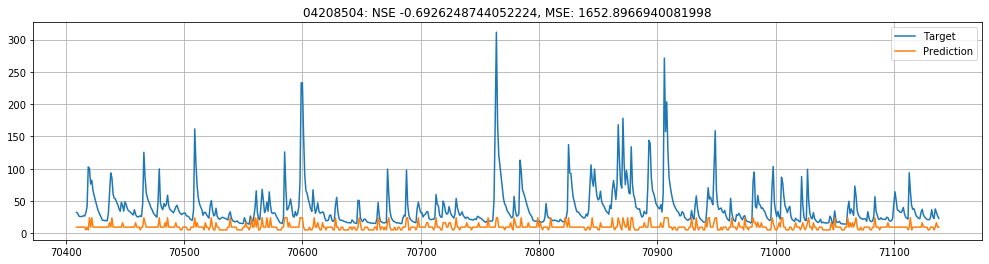

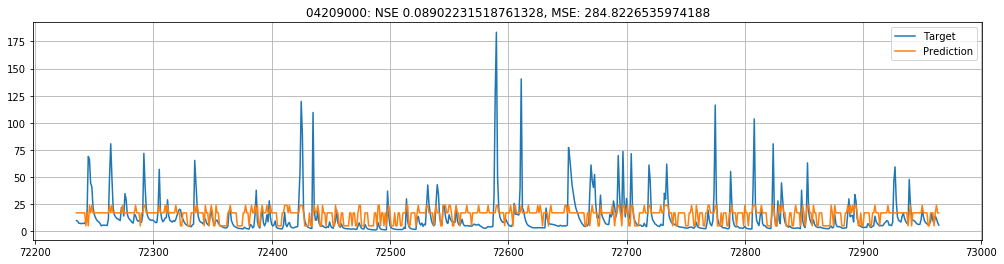

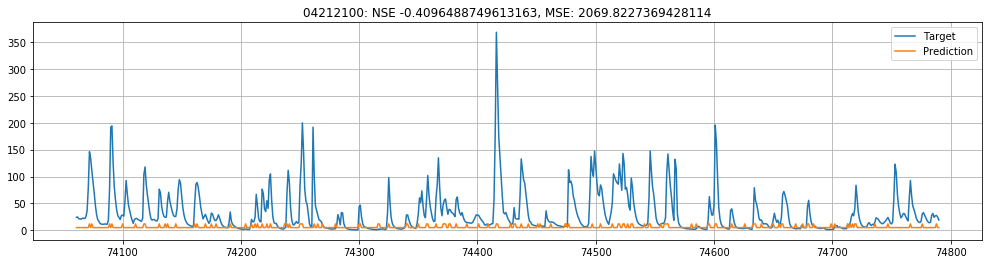

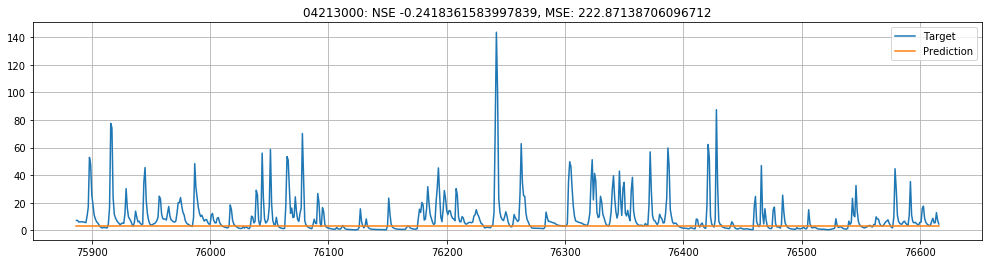

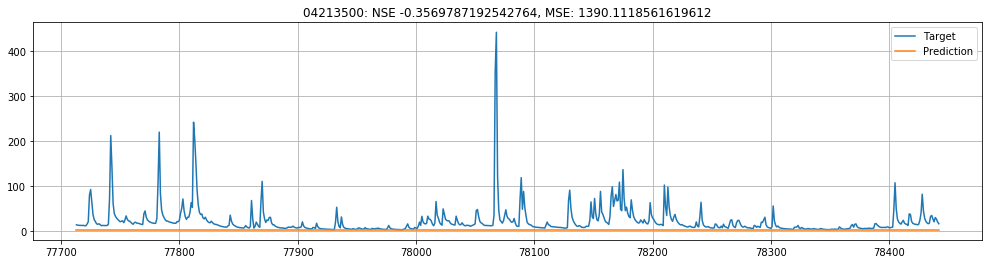

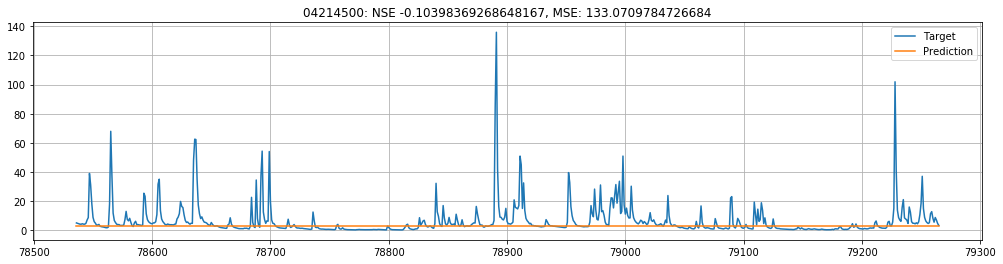

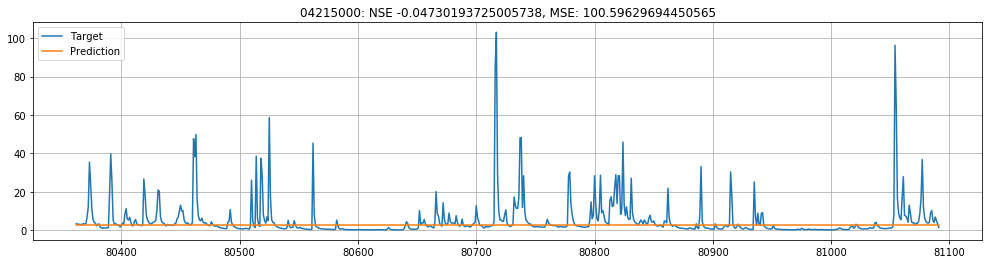

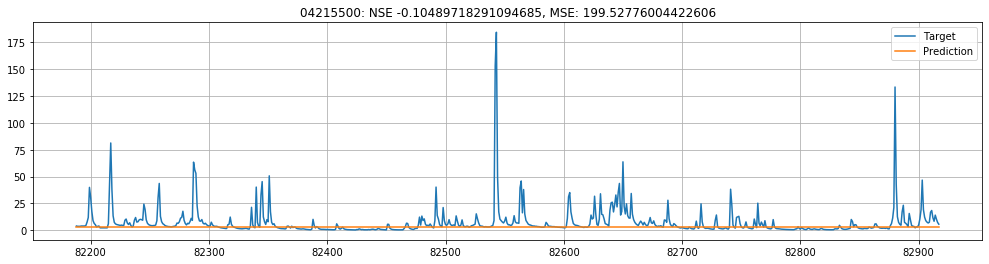

In [8]:
train_nse_list = []
train_mse_list = []
test_nse_list = []
test_mse_list = []
grouped_predict = predict.groupby('station')
for station in grouped_predict.groups.keys():
    station_predict = grouped_predict.get_group(station)
    nse, mse = evaluate.evaluate_daily(station, station_predict[['runoff']], station_predict['actual'], plot=True)
    if station in test_stations:
        test_nse_list.append(nse)
        test_mse_list.append(mse)
    else:
        train_nse_list.append(nse)
        train_mse_list.append(mse)
    
    print(station, '\tNSE:', nse, '\tMSE:', mse, '(clipped to 0)')

print('Train Median NSE (clipped to 0)', np.median(train_nse_list), '/ Min', np.min(train_nse_list), '/ Max', np.max(train_nse_list))
print('Train Median MSE (clipped to 0)', np.median(train_mse_list), '/ Min', np.min(train_mse_list), '/ Max', np.max(train_mse_list))
print('Test Median NSE (clipped to 0)', np.median(test_nse_list), '/ Min', np.min(test_nse_list), '/ Max', np.max(test_nse_list))
print('Test Median MSE (clipped to 0)', np.median(test_mse_list), '/ Min', np.min(test_mse_list), '/ Max', np.max(test_mse_list))

In [9]:
load_data.pickle_results('XGBoost_VIC_aggregateForcings_generalizationTest_withLandcover', predict[['date', 'station', 'runoff', 'actual', 'is_test_station']].rename({'runoff': 'prediction'}, axis=1).reset_index(drop=True), time_stamp)

'XGBoost_VIC_aggregateForcings_generalizationTest_withLandcover_20190728-101329.pkl'

In [10]:
load_data.pickle_model('XGBoost_VIC_aggregateForcings_generalizationTest_withLandcover', m, 'all', time_stamp, model_type='sklearn')

Saved model as ../pickle/models/XGBoost_VIC_aggregateForcings_generalizationTest_withLandcover_all_20190728-101329.pkl


In [11]:
datetime.now().strftime('%Y%m%d-%H%M%S')

'20190728-101855'